# Tutorial team L.E.E.N. meeting
---

### Imports 
---

Import all the required modules.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image  as image
import ipywidgets        as widgets
import numpy             as np

from matplotlib.gridspec import GridSpec
from matplotlib          import rcParams, rc
from scipy.interpolate   import griddata
from astropy             import constants
from sys                 import path

# Change the matplotlib default parameters
rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 150})
rc('font', family='serif')
rc('text', usetex=True)

# Add Magritte directory to the path and import the modules
path.append(f'../Magritte/mesher/')
path.append(f'../Magritte/setup/')
from configure         import get_io, get_simulation
from image             import Image

### Download the data
---

Download the model from the owncloud server. (This might take a minute.)

In [2]:
# link = 'https://owncloud.ster.kuleuven.be/index.php/s/o85x3C8SwFMecxf/download'
# name = 'model.hdf5'

# ! wget --output-document=$name $link 

Alternatively,  use the model that was included in this demo.

In [3]:
name = '../data/model.hdf5'

### Load the data
---

Create an `io` object that will take care of reading and writing data. Use the `io` object to read the simulation data and create a simulation object.

In [4]:
io         = get_io        (name)
simulation = get_simulation(name)

### Assume LTE and ray-trace an image
---

Choose a ray direction `raydir` along which to trace an image and a characteristic stepsize in frequency space `width`.

In [5]:
raydir = 0
width  = 3.0e+3 / constants.c.si.value

Setup spectral discretization, boundary conditions (i.e. inward intensities at the boundary), and initial level populations.

In [6]:
simulation.compute_spectral_discretisation_image (width)
simulation.compute_boundary_intensities          ()
simulation.compute_LTE_level_populations         ()

0

**Without** iteratively computing the Non-LTE level populations, directly trace an (LTE) image.

In [7]:
simulation.compute_and_write_image (io, raydir)

0

Extract the image from the model file.

In [8]:
img = Image(io.io_file, raydir)

To clarify, plot the locations on the image of the points where we have intensity data.

/home/frederik/software/Anaconda3/installation/envs/magritte/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


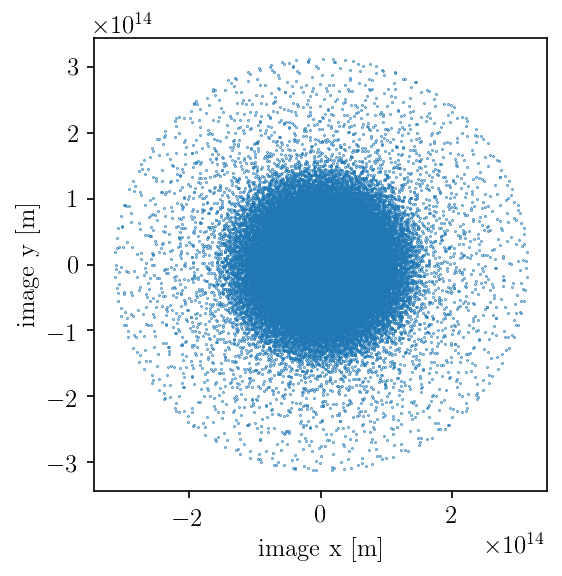

In [9]:
fig = plt.figure(dpi=150)
plt.scatter(img.Xs, img.Ys, s=0.1)
plt.axes().set_aspect('equal')
plt.xlabel('image x [m]')
plt.ylabel('image y [m]')
plt.show()

In [10]:
# Extract the number of frequency bins
nfreqs = simulation.parameters.nfreqs()

# Set number of pixels in x and y direction
ngridx = 200
ngridy = 200

# Set a zoom factor
zoom = 1.5

# Set image boundaries
x_min, x_max = np.min(img.Xs)/zoom, np.max(img.Xs)/zoom
y_min, y_max = np.min(img.Ys)/zoom, np.max(img.Ys)/zoom

# Create image grid values
xs = np.linspace(x_min, x_max, ngridx)
ys = np.linspace(y_min, y_max, ngridy)

# Extract the spectral / velocity data
freqs = np.array(simulation.radiation.frequencies.nu)[0]
f_ij  = np.mean(freqs)
velos = (freqs - f_ij) / f_ij * constants.c.si.value * 1.0e-3   # [km/s]

# Interpolate the scattered data to an image (regular grid)
Is = np.zeros((nfreqs))
zs = np.zeros((nfreqs, ngridx, ngridy))
for f in range(nfreqs):
    zs[f] = griddata((img.Xs, img.Ys), img.Im[:,f], (xs[None,:], ys[:,None]), method='nearest')
    Is[f] = np.sum(zs[f])
Is = Is / np.max(Is)

# Get the logarithm of the data (matplotlib has a hard time handling logarithmic data.)
log_zs     = np.log(zs)
log_zs_min = np.min(log_zs)
log_zs_max = np.max(log_zs)

Make a plot of the (logarithm of the) image data. Capture the output to avoid flooding the notebook.

In [21]:
%%capture

figs = []
gs   = GridSpec(1,2, wspace=.1, width_ratios=[2, 1])

for f in range(nfreqs):
    
    fig = plt.figure(dpi=150)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.contourf(xs, ys, log_zs[f], cmap='magma', vmin=log_zs_min, vmax=log_zs_max, levels=50)
    ax1.set_aspect('equal')
    ax1.set_xlabel('image x [m]', labelpad = 10)
    ax1.set_ylabel('image y [m]', labelpad = 10)
    
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(velos, Is/np.max(Is))
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.axvline(velos[f], c='red')
    ax2.set_ylabel('Relative intensity', labelpad=15)
    ax2.set_xlabel('velocity [km/s]',    labelpad=10)
    asp = 2*np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
    ax2.set_aspect(asp)
    
    plt.savefig(f"image_{f:0>3d}.png", bbox_inches='tight')
    
    figs.append(fig)

Create a simple slider to "walk" through the synthetic data.

In [12]:
widgets.interact(lambda f: figs[f], f=(0, len(figs)-1, 1))

interactive(children=(IntSlider(value=37, description='f', max=74), Output()), _dom_classes=('widget-interact'…

<function __main__.<lambda>(f)>

In [22]:
from glob import glob
fileNames = glob("image*.png")
fileNames.sort()
fileNames

['image_000.png',
 'image_001.png',
 'image_002.png',
 'image_003.png',
 'image_004.png',
 'image_005.png',
 'image_006.png',
 'image_007.png',
 'image_008.png',
 'image_009.png',
 'image_010.png',
 'image_011.png',
 'image_012.png',
 'image_013.png',
 'image_014.png',
 'image_015.png',
 'image_016.png',
 'image_017.png',
 'image_018.png',
 'image_019.png',
 'image_020.png',
 'image_021.png',
 'image_022.png',
 'image_023.png',
 'image_024.png',
 'image_025.png',
 'image_026.png',
 'image_027.png',
 'image_028.png',
 'image_029.png',
 'image_030.png',
 'image_031.png',
 'image_032.png',
 'image_033.png',
 'image_034.png',
 'image_035.png',
 'image_036.png',
 'image_037.png',
 'image_038.png',
 'image_039.png',
 'image_040.png',
 'image_041.png',
 'image_042.png',
 'image_043.png',
 'image_044.png',
 'image_045.png',
 'image_046.png',
 'image_047.png',
 'image_048.png',
 'image_049.png',
 'image_050.png',
 'image_051.png',
 'image_052.png',
 'image_053.png',
 'image_054.png',
 'image_05

In [23]:
import imageio
images = []
for filename in fileNames:
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images)

In [10]:
np.min(img.Im)

3.41515201503345e-18

In [11]:
np.max(img.Im)

7.282983635442486e-15